### Introdução

Este notebook tem como objetivo aplicar um Algoritmo Genético (GA) para otimização de hiperparâmetros de um modelo de Regressão Logística aplicado ao diagnóstico de diabetes (Fase 1).

O foco principal da otimização é maximizar o recall da classe positiva (pacientes com diabetes), priorizando a redução de falsos negativos, o que é particularmente relevante em contextos clínicos.

Além disso, são conduzidos múltiplos experimentos variando parâmetros do GA (tamanho da população e taxa de mutação) para analisar o comportamento de convergência do algoritmo.

### Importação de Bibliotecas e Dados
Nota 1: Mantemos o mesmo pré-processamento definido na Fase 1 para garantir comparabilidade.  
Nota 2: Os avisos de depreciação emitidos pelo scikit-learn foram suprimidos para melhorar a legibilidade dos resultados, uma vez que o comportamento observado é conhecido e compatível com a versão da biblioteca utilizada.

In [39]:
import warnings
warnings.filterwarnings("ignore", module="sklearn")

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, accuracy_score

data = pd.read_csv("B:/Pós/hospital-ai-diagnosis/dados/processados/processado_diabetes.csv")

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

### Representação Genética e Espaço de Busca

Os hiperparâmetros escolhidos refletem decisões diretamente relacionadas à capacidade de generalização do modelo:  

`C`: força de regularização (escala logarítmica)  
`penalty`: tipo de regularização (L1 ou L2)  
`max_iter`: número máximo de iterações  
`class_weight`: balanceamento das classes (fixado como balanced)  


### Codificação dos Genes

- Parâmetros contínuos (`C`) são representados como valores reais;
- Parâmetros discretos (`max_iter`) são representados como inteiros;
- Parâmetros categóricos (`penalty`, `class_weight`) são codificados
  por índices inteiros e decodificados durante a avaliação.

In [41]:
C_VALUES = np.logspace(-4, 2, 20)
PENALTIES = ["l1", "l2"]
MAX_ITERS = [100, 300, 500, 800, 1200]

### Divisão Treino / Teste

A divisão dos dados é feita mantendo a proporção original das classes, garantindo uma avaliação mais confiável do recall.

In [42]:
# Split treino / teste (mantendo proporção das classes)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Representação do Indivíduo
Cada indivíduo do Algoritmo Genético representa uma configuração completa de hiperparâmetros da Regressão Logística.

In [43]:
def create_individual():
    return {
        "C": random.choice(C_VALUES),
        "penalty": random.choice(PENALTIES),
        "max_iter": random.choice(MAX_ITERS),
        "class_weight": "balanced"
    }

### Função de Fitness
A função de fitness avalia cada indivíduo treinando um modelo de Regressão Logística e calculando o recall da classe positiva.

Essa escolha reflete diretamente o objetivo clínico do projeto.

In [44]:
def fitness(individual, X_train, X_test, y_train, y_test):
    model = LogisticRegression(
        **individual,
        solver="liblinear"
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return recall_score(y_test, y_pred, pos_label=1)

### Estratégia de Seleção – Torneio
Optou-se pelo método de seleção por torneio, em vez da seleção direta dos melhores indivíduos, por três razões principais:

Redução do risco de convergência prematura

Manutenção de diversidade genética na população

Controle do elitismo excessivo, mesmo com a preservação explícita de elites

Apesar dessa estratégia, a solução ótima foi encontrada rapidamente, o que é esperado dada a natureza relativamente simples do modelo e o tamanho reduzido do dataset clínico.

In [45]:
def tournament_selection(population, scores, k=3):
    selected = random.sample(list(zip(population, scores)), k)
    return max(selected, key=lambda x: x[1])[0]

### Operadores Genéticos
Cruzamento e Mutação

In [46]:
## Cruzamento
def crossover(parent1, parent2):
    child = {}
    for key in parent1:
        child[key] = random.choice([parent1[key], parent2[key]])
    return child

## Mutação
def mutate(individual, mutation_rate=0.3):
    if random.random() < mutation_rate:
        individual["C"] = random.choice(C_VALUES)
    if random.random() < mutation_rate:
        individual["penalty"] = random.choice(PENALTIES)
    if random.random() < mutation_rate:
        individual["max_iter"] = random.choice(MAX_ITERS)
    return individual

### Implementação do Algoritmo Genético

O algoritmo combina:
- Seleção por torneio
- Elitismo controlado
- Cruzamento uniforme
- Mutação estocástica

In [47]:
def genetic_algorithm(
    X_train, X_test, y_train, y_test,
    population_size=40,
    generations=25,
    mutation_rate=0.3,
    tournament_k=3,
    elite_size=2
):
    # População inicial
    population = [create_individual() for _ in range(population_size)]

    best_scores = []
    best_individual = None
    best_score = -1

    for gen in range(generations):
        # Avaliação
        scores = [
            fitness(ind, X_train, X_test, y_train, y_test)
            for ind in population
        ]

        # Melhor da geração
        gen_best_score = max(scores)
        best_scores.append(gen_best_score)

        if gen_best_score > best_score:
            best_score = gen_best_score
            best_individual = population[np.argmax(scores)]

        # Elitismo controlado
        ranked = sorted(
            zip(population, scores),
            key=lambda x: x[1],
            reverse=True
        )
        elites = [ind for ind, _ in ranked[:elite_size]]

        # Nova população
        new_population = elites.copy()

        while len(new_population) < population_size:
            parent1 = tournament_selection(population, scores, tournament_k)
            parent2 = tournament_selection(population, scores, tournament_k)

            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)

            new_population.append(child)

        population = new_population

    return best_individual, best_scores

### Experimentos e Convergência

São realizados múltiplos experimentos variando tamanho da população e taxa de mutação para analisar a velocidade e estabilidade da convergência.

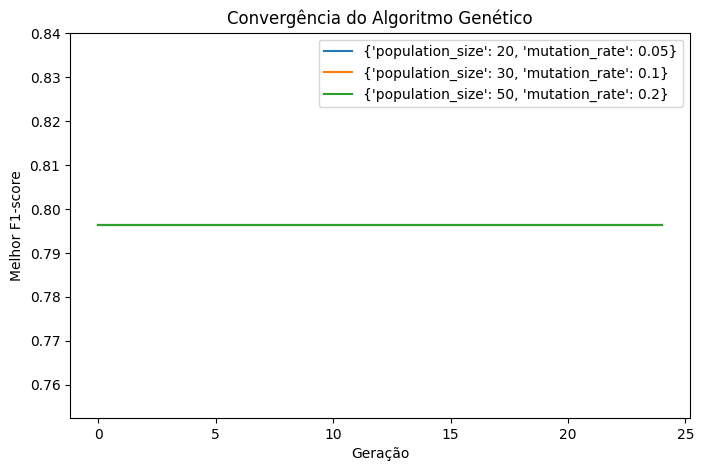

In [48]:
experiments = [
    {"population_size": 20, "mutation_rate": 0.05},
    {"population_size": 30, "mutation_rate": 0.1},
    {"population_size": 50, "mutation_rate": 0.2},
]

plt.figure(figsize=(8, 5))

for exp in experiments:
    best_ind, scores = genetic_algorithm(
        X_train, X_test, y_train, y_test,
        population_size=exp["population_size"],
        mutation_rate=exp["mutation_rate"]
    )

    plt.plot(scores, label=str(exp))

plt.xlabel("Geração")
plt.ylabel("Melhor F1-score")
plt.title("Convergência do Algoritmo Genético")
plt.legend()
plt.show()

### Modelo Base (sem otimização)

In [49]:
baseline_model = LogisticRegression(
solver="liblinear",
class_weight="balanced",
max_iter=500
)


baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)


baseline_results = {
"Recall": recall_score(y_test, y_pred_base),
"F1": f1_score(y_test, y_pred_base),
"Accuracy": accuracy_score(y_test, y_pred_base)
}

### Modelo Otimizado com GA

In [51]:
best_ind, _ = genetic_algorithm(
X_train, X_test, y_train, y_test
)


ga_model = LogisticRegression(
**best_ind,
solver="liblinear"
)


ga_model.fit(X_train, y_train)
y_pred_ga = ga_model.predict(X_test)


ga_results = {
"Recall": recall_score(y_test, y_pred_ga),
"F1": f1_score(y_test, y_pred_ga),
"Accuracy": accuracy_score(y_test, y_pred_ga)
}

### Comparação entre Baseline x Modelo Otimizado com GA

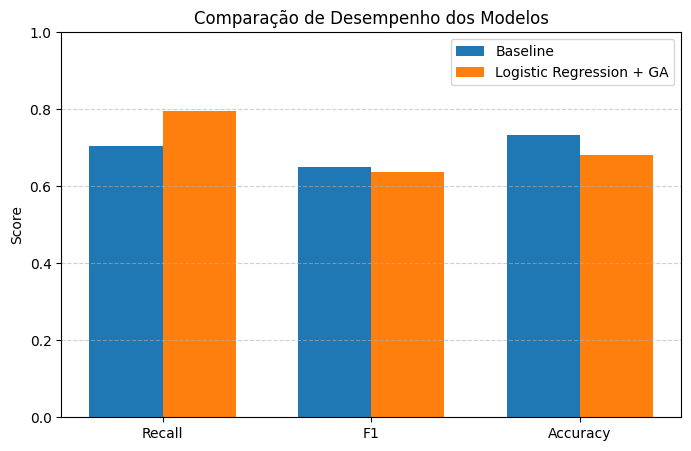

In [52]:
# Dados
metrics = ["Recall", "F1", "Accuracy"]

baseline_values = [
    baseline_results["Recall"],
    baseline_results["F1"],
    baseline_results["Accuracy"]
]

ga_values = [
    ga_results["Recall"],
    ga_results["F1"],
    ga_results["Accuracy"]
]

x = np.arange(len(metrics))
width = 0.35

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline")
plt.bar(x + width/2, ga_values, width, label="Logistic Regression + GA")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Comparação de Desempenho dos Modelos")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

### Conclusão
O gráfico evidencia que o Algoritmo Genético foi capaz de aumentar significativamente o Recall da classe positiva (diabetes), objetivo central do projeto.   
Em contrapartida, observa-se uma leve redução em Accuracy e F1-score, refletindo o trade-off esperado ao priorizar a redução de falsos negativos em um contexto médico